In [27]:
%%capture

!pip install gdown gpxpy geopy osmium contextily

In [14]:
%%capture

import gdown

DRIVE_FOLDER = 'https://drive.google.com/drive/folders/1rOMhQEdYCnan2TpjPcX8zXjVQcPyzy9w?usp=sharing'
gdown.download_folder(DRIVE_FOLDER, quiet=True)

In [32]:
import gpxpy
import pandas as pd
from geopy.distance import geodesic

def parse_gpx(filepath):
  gpx_file = open(filepath, 'r')
  gpx = gpxpy.parse(gpx_file)

  data = []
  last_point = None

  for track in gpx.tracks:
    for segment in track.segments:
      for point in segment.points:
        lat, lng = point.latitude, point.longitude

        current_point = (lat, lng)

        distance = None
        if last_point:
            distance = geodesic(last_point, current_point).meters

        last_point = current_point

        data.append({
          'lat': lat,
          'lon': lng,
          'distance': distance,
        })

  return pd.DataFrame(data)

gpx_df = parse_gpx('/content/running track/sample.gpx')
gpx_df.head()

,lat,lon,distance
0,20.994695,105.870317,NaN
1,20.994711,105.870320,1.859333
2,20.994744,105.870327,3.718666
3,20.994795,105.870328,5.556970
4,20.994812,105.870329,1.936651


In [33]:
gpx_df['distance'].describe()

,distance
count,4402.000000
mean,2.757999
std,1.837983
min,0.005324
25%,2.096949
50%,2.814787
75%,3.285308
max,64.855467


In [51]:
import osmium

class WayHandler(osmium.SimpleHandler):
    def __init__(self):
        osmium.SimpleHandler.__init__(self)
        self.ways = []

    def way(self, w):
        way_nodes = []
        for n in w.nodes:
          way_nodes.append((
              float(n.lat),
              float(n.lon),
          ))
        self.ways += way_nodes

handler = WayHandler()
handler.apply_file('/content/running track/track.osm', locations=True)

track_points = handler.ways
len(track_points)

65

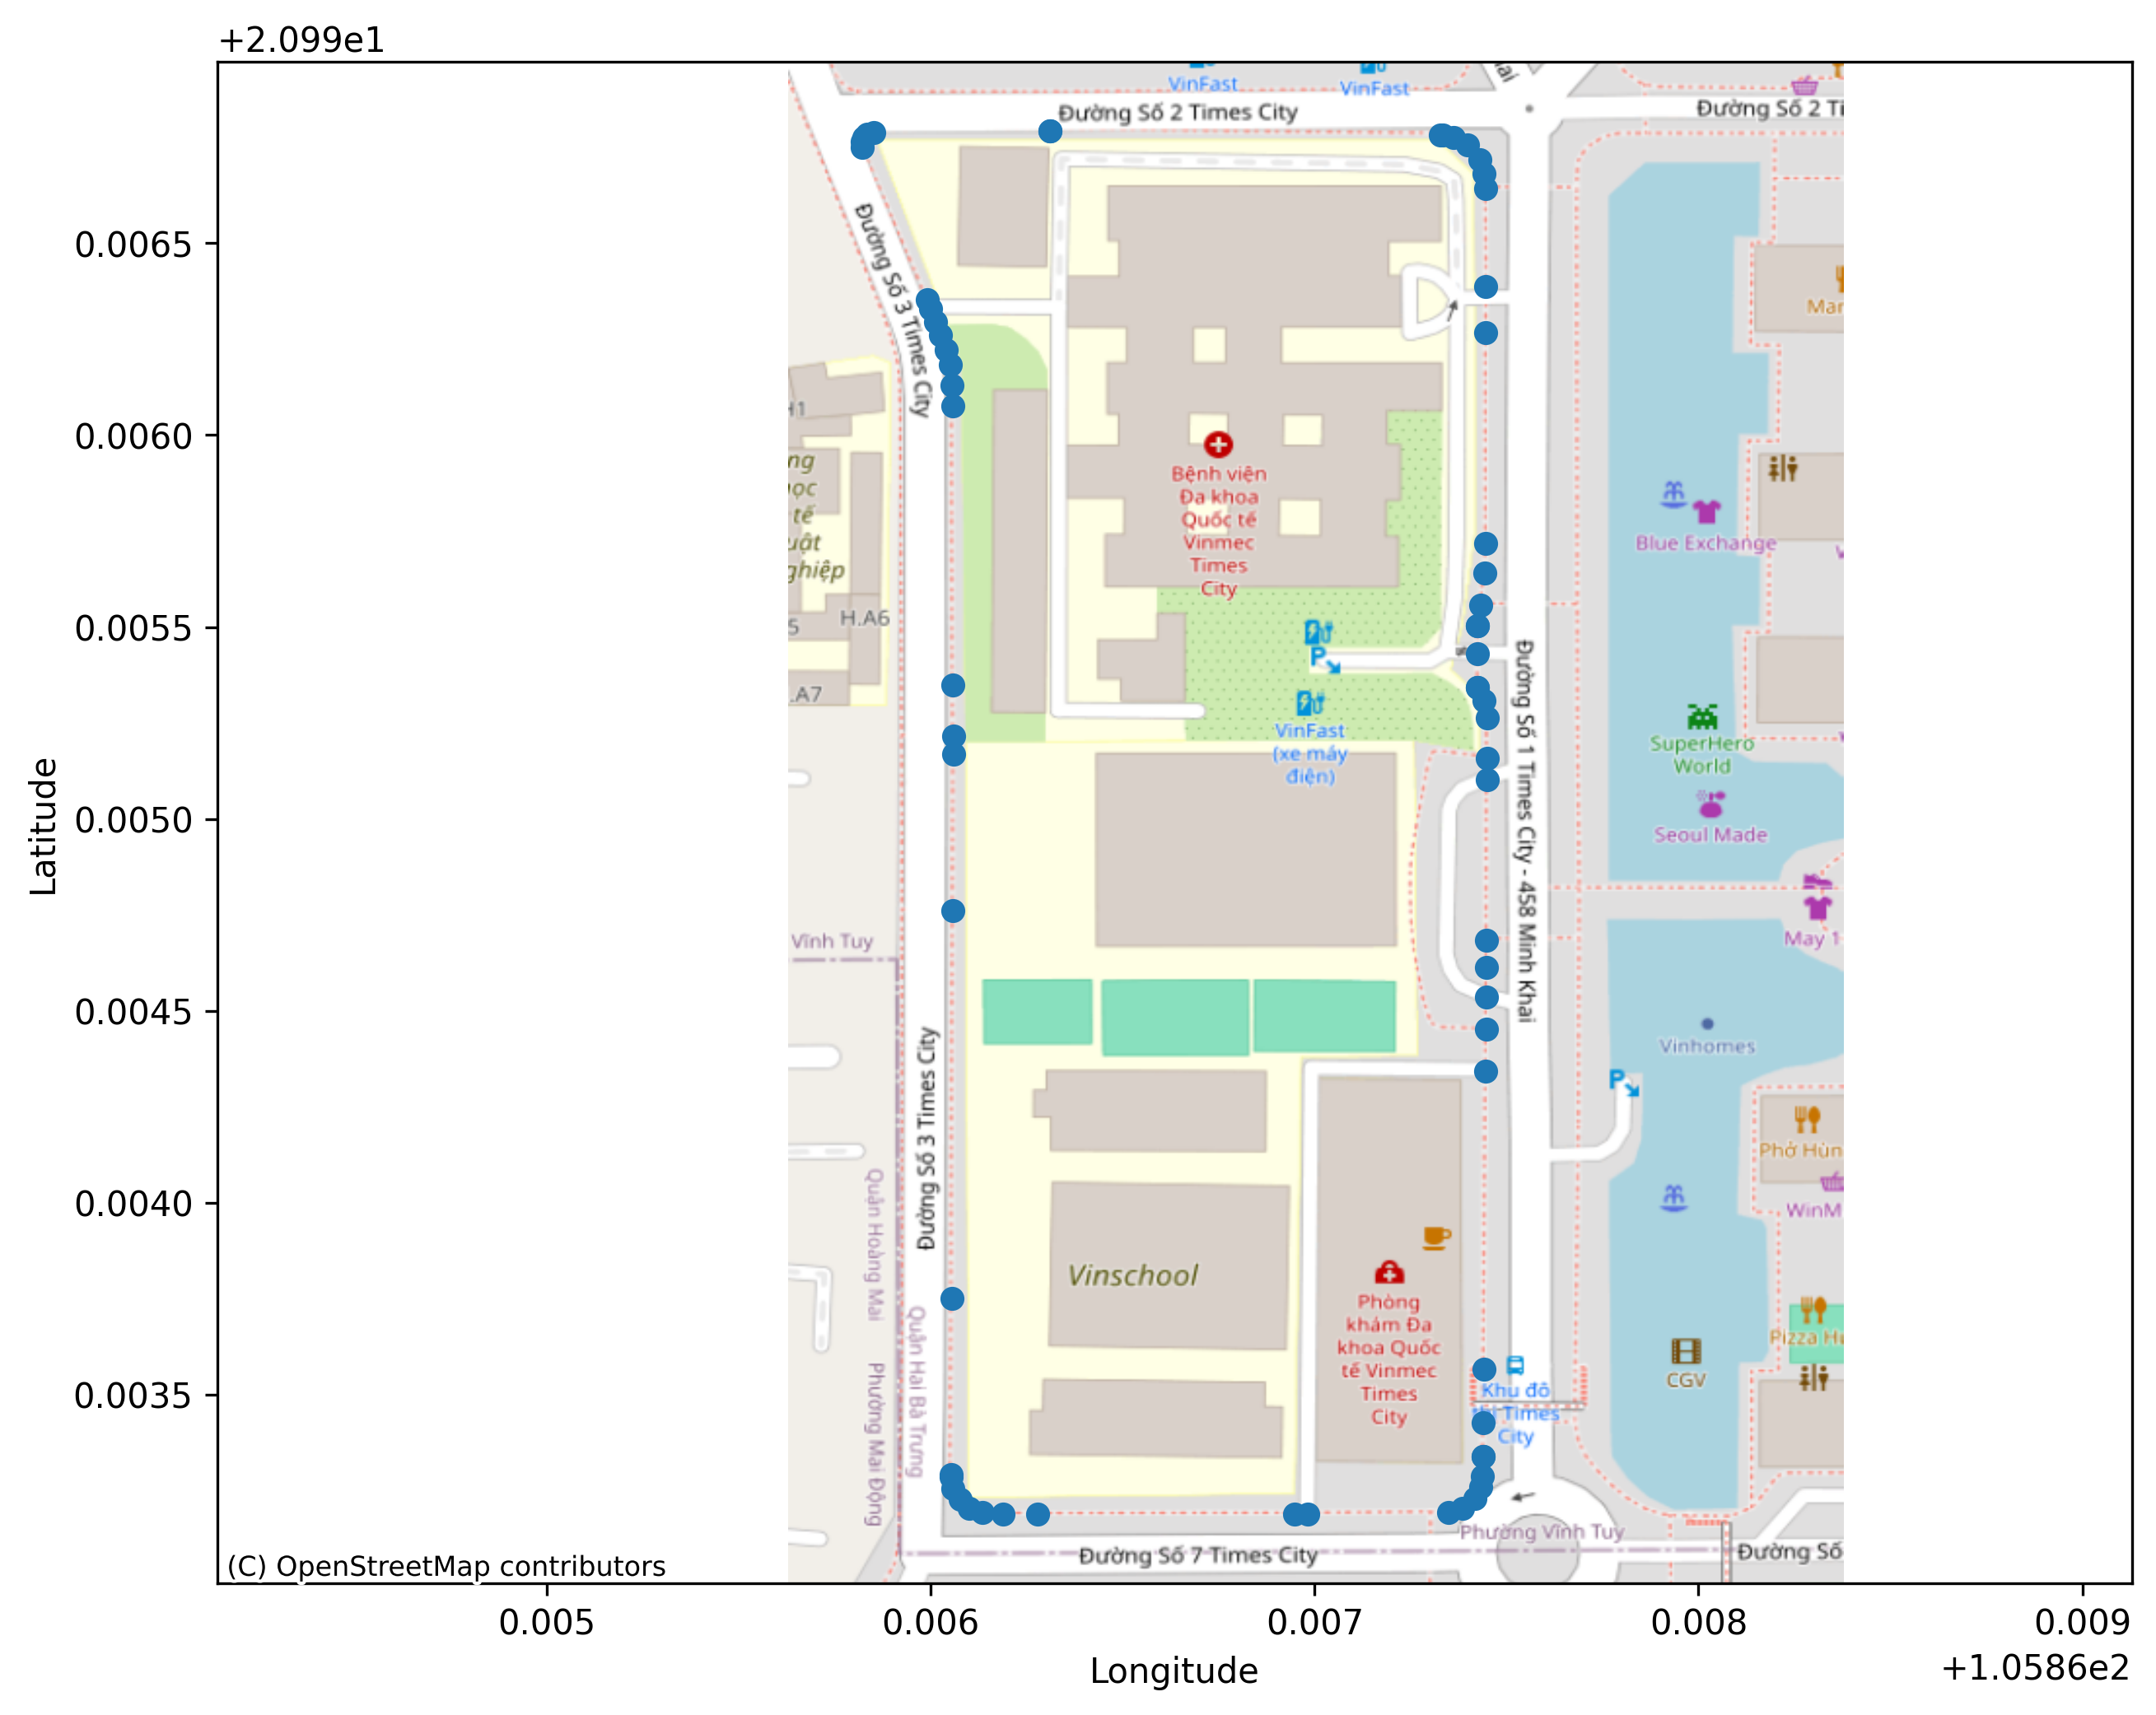

In [52]:
import matplotlib.pyplot as plt
import contextily as ctx

def plot_track(track_points):
  lats = [lat for lat, _ in track_points]
  lons = [lon for _, lon in track_points]
  plt.figure(figsize=(10, 8), dpi=300)
  plt.scatter(lons, lats)
  plt.axis('equal')
  plt.xlabel('Longitude')
  plt.ylabel('Latitude')
  ctx.add_basemap(plt.gca(), crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
  plt.show()

plot_track(track_points)

In [53]:
import math

def tuple_to_angle(center, point):
    """Calculate the angle of a point relative to a center in radians."""
    lat_diff = point[0] - center[0]
    lon_diff = point[1] - center[1]
    return (math.atan2(lon_diff, lat_diff) + 2 * math.pi) % (2 * math.pi)

def sort_clockwise(points):
    if not points:
        return []

    # Calculate centroid as the central point
    center_lat = sum(lat for lat, _ in points) / len(points)
    center_lon = sum(lon for _, lon in points) / len(points)
    center = (center_lat, center_lon)

    # Calculate angles and squared distances for sorting
    points_with_angles = [
        (tuple_to_angle(center, point), (point[0] - center[0])**2 + (point[1] - center[1])**2, point)
        for point in points
    ]

    # Sort by angle and then by squared distance (to avoid unnecessary sqrt)
    points_with_angles.sort(key=lambda x: (x[0], -x[1]))

    # Extract and return the sorted points
    return [point for _, _, point in points_with_angles]

track_points = sort_clockwise(track_points)

In [67]:
from geopy.distance import geodesic
from pyproj import Geod
import math

# Initialize the Geod object for WGS84 ellipsoid
G = Geod(ellps="WGS84")

def interpolate_points(point1, point2, max_distance=3):
    """
    Interpolates points between two geographic points such that the distance
    between consecutive points does not exceed max_distance.

    Args:
        point1 (tuple): Starting point as (latitude, longitude).
        point2 (tuple): Ending point as (latitude, longitude).
        max_distance (float): Maximum distance between consecutive points in meters.

    Returns:
        list: List of interpolated points including point1 and point2.
    """
    points = [point1]
    distance = geodesic(point1, point2).meters
    if distance <= max_distance:
        return points + [point2]

    # Calculate the forward azimuth (bearing) from point1 to point2
    lon1, lat1 = point1[1], point1[0]
    lon2, lat2 = point2[1], point2[0]
    bearing, _, _ = G.inv(lon1, lat1, lon2, lat2)

    # Number of new points needed
    n = math.ceil(distance / max_distance) - 1
    for i in range(1, n + 1):
        fraction = i / (n + 1)
        # Interpolate the new point along the great circle path
        new_point = geodesic(kilometers=fraction * (distance / 1000)).destination((lat1, lon1), bearing)
        points.append((new_point.latitude, new_point.longitude))
    points.append(point2)
    return points

def insert_points(sorted_points, max_distance=3):
    """
    Inserts interpolated points between consecutive points in a list of points.

    Args:
        sorted_points (list): List of geographic points as (latitude, longitude).
        max_distance (float): Maximum distance between consecutive points in meters.

    Returns:
        list: List of points with interpolated points inserted.
    """
    result = []
    for i in range(len(sorted_points) - 1):
        # Interpolate between each pair of points
        interpolated = interpolate_points(sorted_points[i], sorted_points[i + 1], max_distance)
        result.extend(interpolated[:-1])

    interpolated = interpolate_points(sorted_points[0], sorted_points[-1], max_distance)
    result.extend(interpolated[:-1])

    return result

updated_points = insert_points(track_points)
len(updated_points)

403

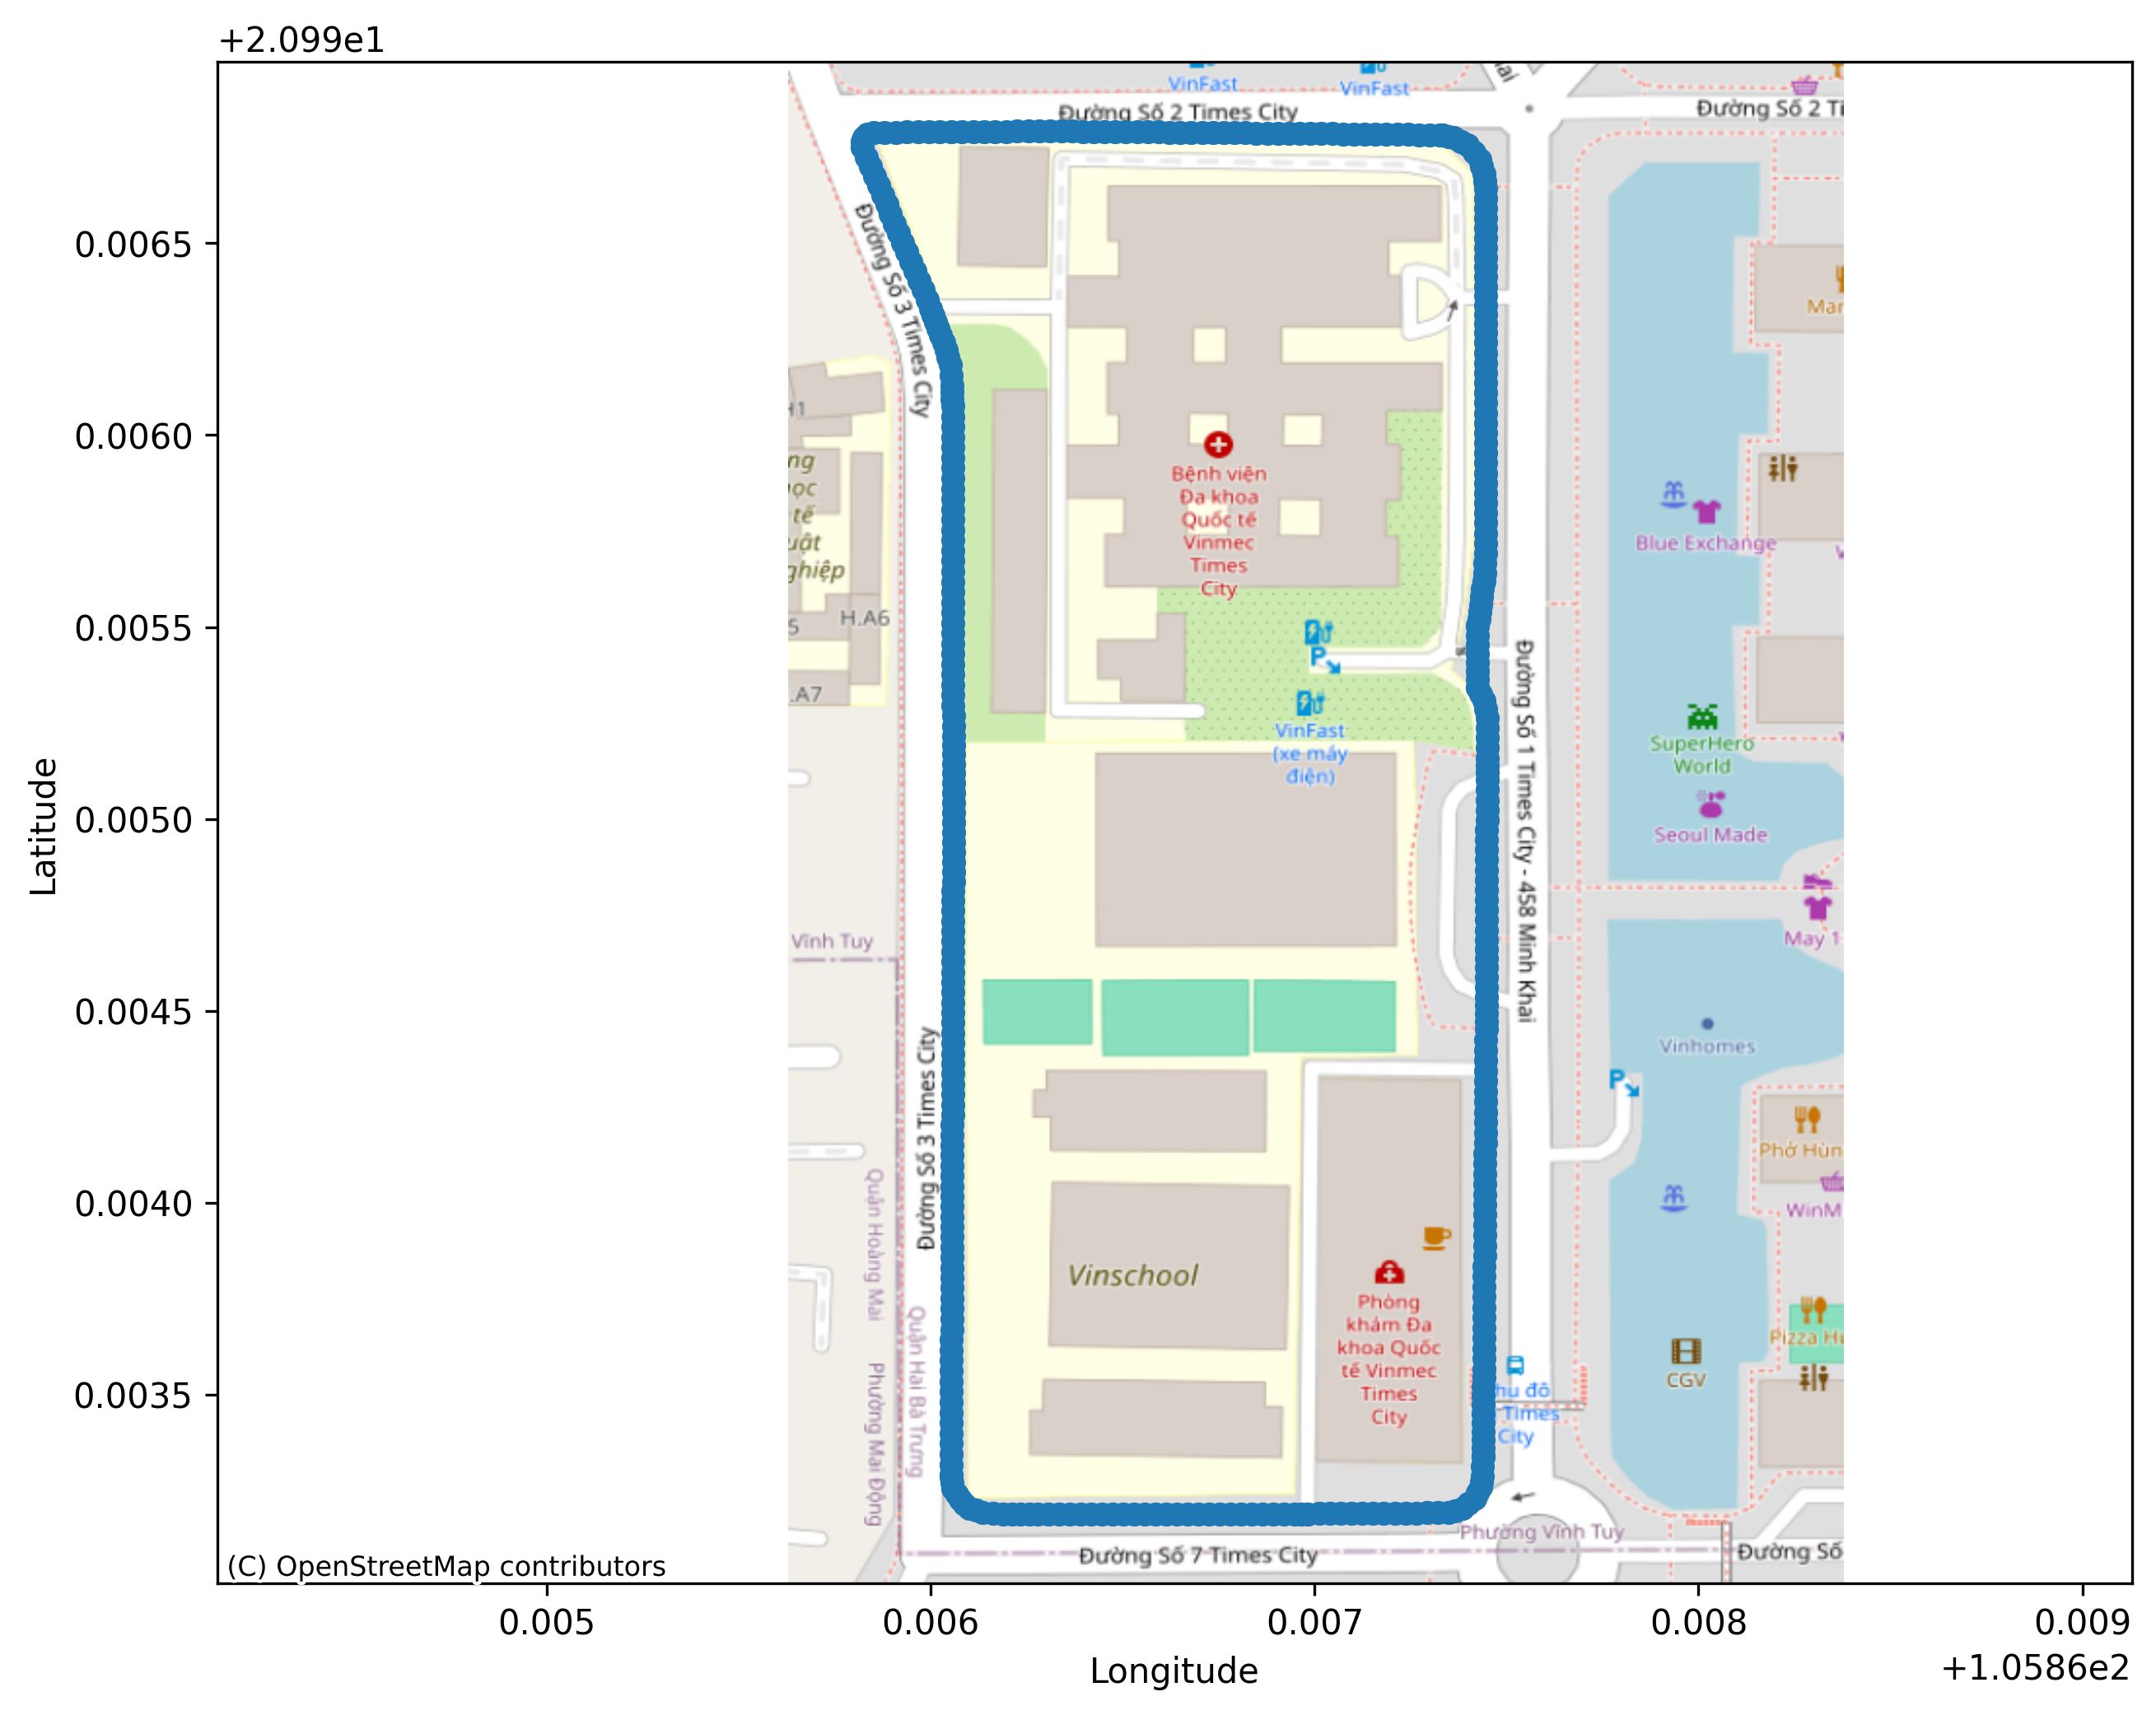

In [68]:
plot_track(updated_points)

In [71]:
import csv

def save_points(points):
  with open("track-points.csv", mode='w', newline='') as file:
      writer = csv.writer(file)
      writer.writerow(["lat", "lon"])
      for row in points:
          writer.writerow(row)

save_points(updated_points)